# Loading Data

In [1]:
# External Dependencies: nltk, transformers, np

import nltk
nltk.download('punkt')
import csv
import json
import sys
from transformers import RobertaTokenizer
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to C:\Users\Harold
[nltk_data]     Rubio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Code base for function provided by: https://github.com/NLPrinceton/SARC
def parse_data(pol=True, lower=True):
    SARC_MAIN = 'main/'
    SARC_POL = 'pol/'

    if pol:
        SARC = SARC_POL
    else:
        SARC = SARC_MAIN

    train_file = SARC+'train-balanced.csv'
    test_file = SARC+'test-balanced.csv'
    comment_file = SARC+'comments.json'

    print('Load SARC data')
    with open(comment_file, 'r') as f:
        comments = json.load(f)

    train_docs = {'ancestors': [], 'responses': []}
    train_stats = {'ancestors': [], 'responses': []}
    train_labels = []
    with open(train_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            labels = row[2].split(' ')

            if lower:
                # For each ancestor comment
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    # Add single comment to list of comments
                    comment_list.append(comments[r]['text'].lower())
                    # Create dictionary of additional information about comment
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    # Add dictionary to list
                    entry_stats.append(comment_entry)
                train_docs['ancestors'].append(comment_list)
                train_stats['ancestors'].append(entry_stats)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['responses'].append(comment_list)
                train_stats['responses'].append(entry_stats)
            else:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['ancestors'].append(comment_list)
                train_stats['ancestors'].append(entry_stats)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['responses'].append(comment_list)
                train_stats['responses'].append(entry_stats)

            train_labels.append(labels)

    test_docs = {'ancestors': [], 'responses': []}
    test_stats = {'ancestors': [], 'responses': []}
    test_labels = []
    with open(test_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            #print('next test entry')
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            labels = row[2].split(' ')

            if lower:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['ancestors'].append(entry_stats)
                test_docs['ancestors'].append(comment_list)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['responses'].append(entry_stats)
                test_docs['responses'].append(comment_list)
            else:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['ancestors'].append(entry_stats)
                test_docs['ancestors'].append(comment_list)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['responses'].append(entry_stats)
                test_docs['responses'].append(comment_list)

            test_labels.append(labels)
    return train_docs, train_labels, test_docs, test_labels, train_stats, test_stats

In [3]:
is_pol = False
train_docs, train_labels, test_docs, test_labels, train_stats, test_stats = parse_data(pol=is_pol)

Load SARC data


# Setting up helper functions

In [16]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_resp = train_docs['responses']
train_resp_stats = train_stats['responses']
train_resp_labels = train_labels

test_resp = test_docs['responses']
test_resp_stats = test_stats['responses']
test_resp_labels = test_labels

In [17]:
def write_to_file_ntlk(data_file, data, labels, stats=None):
    counter = 0
    with open(data_file, 'w') as f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                counter += 1
                toks = nltk.tokenize.word_tokenize(data[i][j])
                label = labels[i][j]
                f.write(str(counter) + " " + str(label) + " " + " ".join(toks) + '\n')

def write_to_file_rob(data_file, data, labels, stats=None):
    counter = 0
    with open(data_file, 'w') as f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                counter += 1
                label = labels[i][j]
                toks = tokenizer(data[i][j])['input_ids']
                f.write(str(counter) + " " + str(label) + " " + " ".join([str(j) for j in toks]) + '\n')
def write_to_file_ntlk_user(data_file, data, labels, stats=None):
    counter = 0
    with open(data_file, 'w') as f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                counter += 1
                user = stats[i][j]['author']
                label = labels[i][j]
                toks = nltk.tokenize.word_tokenize(data[i][j])
                f.write(str(counter) + " " + str(label) + " " + user + " " +" ".join([str(j) for j in toks]) + '\n')

# Extracting Single-Post Sequences (NLTK)

In [18]:
if is_pol:
    write_to_file_ntlk('train_pol.txt', train_resp, train_resp_labels)
    write_to_file_ntlk('test_pol.txt', test_resp, test_resp_labels)
else:
    write_to_file_ntlk('train_main.txt', train_resp, train_resp_labels)
    write_to_file_ntlk('test_main.txt', test_resp, test_resp_labels)

# Extracting Single-Post Sequences (RoBERTa)

In [19]:
if is_pol:
    write_to_file_rob('train_pol_rob.txt', train_resp, train_resp_labels)
    write_to_file_rob('test_pol_rob.txt', test_resp, test_resp_labels)
else:
    write_to_file_rob('train_main_rob.txt', train_resp, train_resp_labels)
    write_to_file_rob('test_main_rob.txt', test_resp, test_resp_labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (931 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors


# Extracting Single-Post User-Labeled Sequences (NLTK)

In [15]:
if is_pol:
    write_to_file_ntlk_user('train_pol_users.txt', train_resp, train_resp_labels, stats=train_resp_stats)
    write_to_file_ntlk_user('test_pol_users.txt', test_resp, test_resp_labels, stats=test_resp_stats)
else:
    write_to_file_ntlk_user('train_main_users.txt', train_resp, train_resp_labels, stats=train_resp_stats)
    write_to_file_ntlk_user('test_main_users.txt', test_resp, test_resp_labels, stats=test_resp_stats)

# Build GLoVE

In [11]:
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Looking at OOV words/tokens

In [9]:
from collections import defaultdict
from collections import Counter

In [12]:
c = Counter()
train_anc = train_docs['ancestors']
train_resp = train_docs['responses']
test_anc = test_docs['ancestors']
test_resp = test_docs['responses']
for k in train_docs.keys():
    for i in range(len(train_docs[k])):
        for j in range(len(train_docs[k][i])):
            c.update(nltk.tokenize.word_tokenize(train_docs[k][i][j]))
            
    for i in range(len(test_docs[k])):
        for j in range(len(test_docs[k][i])):
            c.update(nltk.tokenize.word_tokenize(test_docs[k][i][j]))


not_vocab = Counter()
for w in list(c):
    if w not in embeddings_index.keys():
        not_vocab.update({w: c[w]})


In [21]:
print('vocabulary size: %d' % len(list(c)))
print('out-of-glove vocab: %d' % len(list(not_vocab)))
print('type percentage: %.3f%%' % (100*len(list(not_vocab))/len(list(c))))
print('token percentage: %.3f%%' % (100*sum(not_vocab.values())/sum(c.values())))
print('number of tokens: %d' % sum(c.values()))
print(not_vocab.most_common(10))

vocabulary size: 145542
out-of-glove vocab: 68050
type percentage: 46.756%
token percentage: 2.078%
number of tokens: 6100626
[('..', 3205), ('subreddit', 686), ('lmao', 512), ('uint8', 512), ('nsfw', 476), ('nbsp', 430), ('trihard', 385), ('mrw', 376), ('inb4', 374), ('amirite', 362)]


# Author Upvote Distribution

In [22]:
authors = defaultdict(int)
for k in train_docs.keys(): # Selecting responses/ancestors
    for i in range(len(train_docs[k])): # Selecting example number
        for j in range(len(train_docs[k][i])): # Selecting response/ancestor number
            curr_dict = train_stats[k][i][j]
            authors[curr_dict['author']] += curr_dict['ups']
            
    for i in range(len(test_docs[k])):
        for j in range(len(test_docs[k][i])):
            curr_dict = test_stats[k][i][j]
            authors[curr_dict['author']] += curr_dict['ups']

not_vocab = 0
ac = Counter(authors)
print(ac.most_common(10))

[('[deleted]', 8090529), ('maxwellhill', 927925), ('GallowBoob', 809962), ('SlimJones123', 542914), ('iBleeedorange', 369702), ('anewhigh', 300997), ('anutensil', 291381), ('Zykium', 286039), ('dustofoblivion123', 262979), ('ArkadiusBear', 258420)]
145542


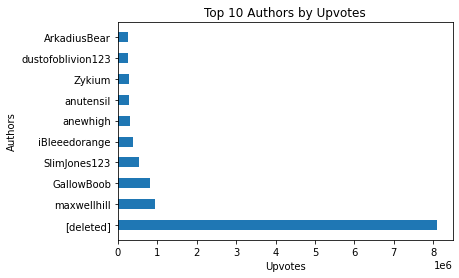

In [40]:
top_10 = ac.most_common(10)
authors, upvotes = [], []
for author, count in top_10:
    authors.append(author)
    upvotes.append(count)
plt.figure()
plt.barh(10*np.arange(len(authors)), upvotes, height=4.8)
plt.yticks(10*np.arange(len(authors)), authors)
plt.title('Top 10 Authors by Upvotes')
plt.xlabel('Upvotes')
plt.ylabel('Authors')
plt.show()

# Authorship Distribution

In [12]:
written_by = Counter()
written_by_dist = {}
k = 'responses'
for i in range(len(train_docs[k])): # Selecting example number
    for j in range(len(train_docs[k][i])): # Selecting response/ancestor number
        curr_dict = train_stats[k][i][j]
        written_by.update({curr_dict['author']: 1})
'''    
for i in range(len(test_docs[k])):
    for j in range(len(test_docs[k][i])):
        curr_dict = test_stats[k][i][j]
        written_by.update({curr_dict['author']: 1})
'''
NUM_POSTS = sum(written_by.values())
NUM_AUTHORS = len(written_by.keys())
#Obtain probability distribution
for author, count in written_by.items():
    written_by_dist[author] = count / NUM_POSTS

print(written_by.most_common(20))

[('[deleted]', 2833), ('mindlessrabble', 99), ('mad-n-fla', 84), ('Chaoslab', 72), ('IrishJoe', 66), ('ivsciguy', 63), ('gonzone', 59), ('JacobCrim88', 51), ('DownvoteDaemon', 51), ('pokemon_fetish', 51), ('pixelwhip', 50), ('EggCouncil', 48), ('tau-lepton', 43), ('TodaysIllusion', 41), ('JumpingJazzJam', 41), ('NeonDisease', 41), ('sleaze_bag_alert', 39), ('Gamer_152', 38), ('duggtodeath', 37), ('Canada_girl', 37)]


In [13]:
print(f'num authors: {NUM_AUTHORS}')
print(f'num posts: {NUM_POSTS}')

num authors: 183249
num posts: 257082


[deleted] accounts for 1.12% of all posts


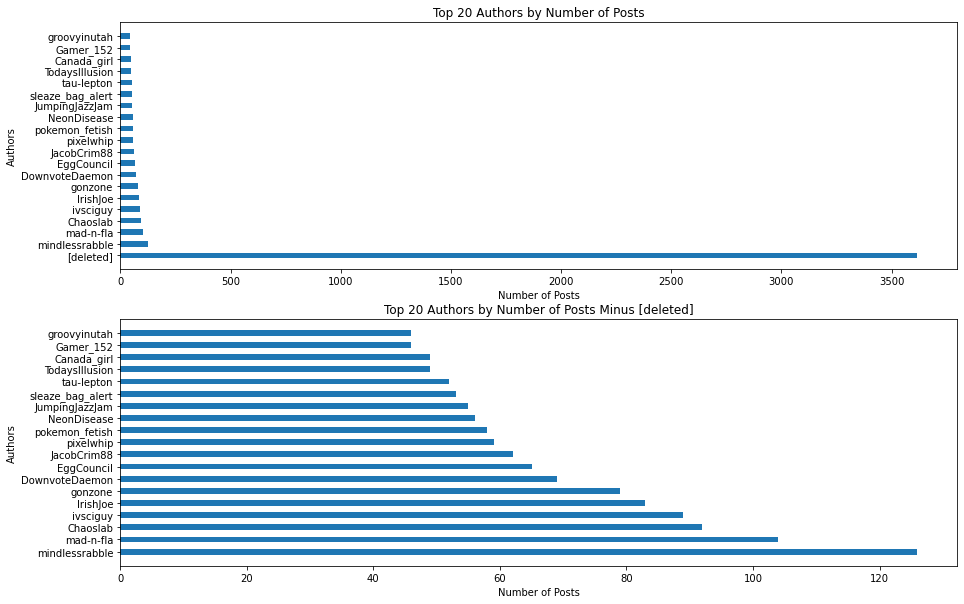

In [52]:
top_20 = written_by.most_common(20)
authors, num_posts = [], []
deleted_posts = written_by['[deleted]']
print(f'[deleted] accounts for {deleted_posts/NUM_POSTS*100:4.2f}% of all posts')
for author, count in top_20:
    authors.append(author)
    num_posts.append(count)
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.barh(10*np.arange(len(authors)), num_posts, height=4.8)
plt.yticks(10*np.arange(len(authors)), authors)
plt.title('Top 20 Authors by Number of Posts')
plt.xlabel('Number of Posts')
plt.ylabel('Authors')

authors = authors[1:]
num_posts = num_posts[1:]
plt.subplot(2, 1, 2)
plt.barh(10*np.arange(len(authors)), num_posts, height=4.8)
plt.yticks(10*np.arange(len(authors)), authors)
plt.title('Top 20 Authors by Number of Posts Minus [deleted]')
plt.xlabel('Number of Posts')
plt.ylabel('Authors')
plt.show()

number of posts 321748
Posts Per Author | Percentage of Posts Covered | Percentage of Authors Covered
01 | 98.88% | 100.00%
02 | 45.59% | 21.70%
03 | 27.82% | 8.65%
04 | 19.33% | 4.49%
05 | 14.33% | 2.66%
06 | 11.21% | 1.74%
07 | 9.04% | 1.21%
08 | 7.40% | 0.86%
09 | 6.28% | 0.66%
10 | 5.37% | 0.51%


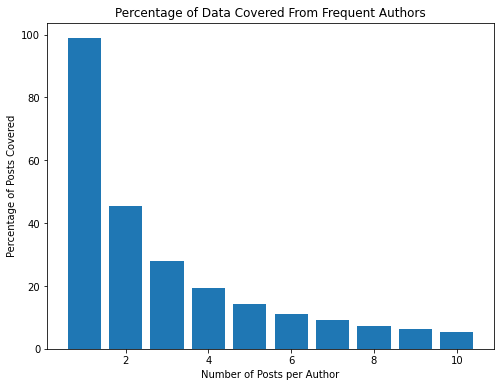

In [50]:
#top_20 = written_by.most_common(20)
percentages = []
authors_accounted = []
num = NUM_POSTS
MAX_POSTS = 11
for sig_post in range(1, MAX_POSTS):
    post_sum = 0
    author_count = 0
    for author, count in written_by.items():
        if author == '[deleted]':
            continue
        if count >= sig_post:
            post_sum += count
            author_count += 1
    authors_accounted.append(author_count / NUM_AUTHORS * 100)
    percentages.append(post_sum / num * 100)
print(f'number of posts {num}')
print('Posts Per Author | Percentage of Posts Covered | Percentage of Authors Covered')
for p in range(len(percentages)):
    print(f'{p+1:02d} | {percentages[p]:04.2f}% | {authors_accounted[p]:04.2f}%')
plt.figure(figsize=(8, 6))
plt.bar(range(1, MAX_POSTS), percentages)
plt.title('Percentage of Data Covered From Frequent Authors')
plt.xlabel('Number of Posts per Author')
plt.ylabel('Percentage of Posts Covered')
plt.show()
